# Cal-CRAI Index: Weighting Climate Risk Scenarios

**Order of operations**:
1) Metric handling \
   a) Retrieve & clean data \
   b) Merge data domains together \
   c) Calculate domain medians and adjusted scores \
   d) Pull climate domain and clean & merge

2) Custom weight per scenairo
   * save each scenario as csv
   
3) Bin data \
   a) Merge index scores per scenario together \
   b) Bin values into 5 sections per scenario \
   c) Visualize the binned weighted scenarios

4) Upload each scenario index .csv to AWS

In [1]:
import pandas as pd
import numpy as np
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.cal_crai_calculations import calculate_weighted_index, weight_domains, print_index_summary
from scripts.utils.cal_crai_plotting import index_plot, plot_hazard_score

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_environment_domain_score.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_score.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_systems_domain_score.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_score.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_hazard_scores.csv')

### Clean data, isolate relevant columns

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]

# For climate domain, keep first seven columns
climate_domain_cleaned = climate_domain.iloc[:, :7]

### 1b) Merge data domains together

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score
0,06001400100,0.440547,0.605062,0.614842,0.833488
1,06001400200,0.440547,0.553534,0.514427,0.841855
2,06001400300,0.440547,0.557473,0.472358,0.793298
3,06001400400,0.440547,0.549355,0.501336,0.770451
4,06001400500,0.440547,0.552923,0.463199,0.744977
...,...,...,...,...,...
9124,06115040902,0.567018,0.468943,0.609509,0.783342
9125,06115041001,0.516407,0.416459,0.653322,0.742681
9126,06115041002,0.602291,0.432561,0.640815,0.766956
9127,06115041101,0.563770,0.391202,0.674908,0.736324


### 1c) Calculate data domain median and adjusted columns

In [7]:
all_domains = merged_domains.copy()
all_domains['built_environment_median'] = merged_domains['built_environment_domain_score'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_score'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_score'].median()

all_domains

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median
0,06001400100,0.440547,0.605062,0.614842,0.833488,0.642475,0.593307,0.748805
1,06001400200,0.440547,0.553534,0.514427,0.841855,0.642475,0.593307,0.748805
2,06001400300,0.440547,0.557473,0.472358,0.793298,0.642475,0.593307,0.748805
3,06001400400,0.440547,0.549355,0.501336,0.770451,0.642475,0.593307,0.748805
4,06001400500,0.440547,0.552923,0.463199,0.744977,0.642475,0.593307,0.748805
...,...,...,...,...,...,...,...,...
9124,06115040902,0.567018,0.468943,0.609509,0.783342,0.642475,0.593307,0.748805
9125,06115041001,0.516407,0.416459,0.653322,0.742681,0.642475,0.593307,0.748805
9126,06115041002,0.602291,0.432561,0.640815,0.766956,0.642475,0.593307,0.748805
9127,06115041101,0.563770,0.391202,0.674908,0.736324,0.642475,0.593307,0.748805


In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_score'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built_environment']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted
0,06001400100,0.440547,0.605062,0.614842,0.833488,0.642475,0.593307,0.748805,0.036298,0.113091,-0.058232
1,06001400200,0.440547,0.553534,0.514427,0.841855,0.642475,0.593307,0.748805,-0.132950,0.124264,-0.138434
2,06001400300,0.440547,0.557473,0.472358,0.793298,0.642475,0.593307,0.748805,-0.203855,0.059419,-0.132304
3,06001400400,0.440547,0.549355,0.501336,0.770451,0.642475,0.593307,0.748805,-0.155014,0.028908,-0.144939
4,06001400500,0.440547,0.552923,0.463199,0.744977,0.642475,0.593307,0.748805,-0.219291,-0.005111,-0.139386
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.567018,0.468943,0.609509,0.783342,0.642475,0.593307,0.748805,0.027309,0.046124,-0.270099
9125,06115041001,0.516407,0.416459,0.653322,0.742681,0.642475,0.593307,0.748805,0.101154,-0.008179,-0.351789
9126,06115041002,0.602291,0.432561,0.640815,0.766956,0.642475,0.593307,0.748805,0.080074,0.024240,-0.326726
9127,06115041101,0.563770,0.391202,0.674908,0.736324,0.642475,0.593307,0.748805,0.137537,-0.016668,-0.391102


## 1d) Pull climate domain and clean & merge

In [9]:
climate_domain_cleaned

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,6001400100,0.753671,0.878232,0.769035,0.617510,0.304982,0.546436
1,6001400200,0.704640,0.878232,0.792429,0.409643,0.323460,0.605283
2,6001400300,0.764024,0.852784,0.828517,0.614542,0.283089,0.605283
3,6001400400,0.702309,0.852784,0.828517,0.406913,0.305819,0.605283
4,6001400500,0.781995,0.852784,0.828517,0.614532,0.316931,0.605283
...,...,...,...,...,...,...,...
9124,6115040902,0.409434,0.324800,0.382787,0.619160,NaN,0.846492
9125,6115041001,0.382023,0.311958,0.374011,0.527876,NaN,0.873744
9126,6115041002,0.396227,0.322660,0.377173,0.585439,NaN,0.819991
9127,6115041101,0.361174,0.353338,0.322773,0.539505,NaN,0.651207


### Clean climate dataframe

In [10]:
# Ensure all values in GEOID are strings
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

# Display the dataframe
climate_domain_cleaned

,GEOID,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,06001400100,0.753671,0.878232,0.769035,0.617510,0.304982,0.546436
1,06001400200,0.704640,0.878232,0.792429,0.409643,0.323460,0.605283
2,06001400300,0.764024,0.852784,0.828517,0.614542,0.283089,0.605283
3,06001400400,0.702309,0.852784,0.828517,0.406913,0.305819,0.605283
4,06001400500,0.781995,0.852784,0.828517,0.614532,0.316931,0.605283
...,...,...,...,...,...,...,...
9124,06115040902,0.409434,0.324800,0.382787,0.619160,NaN,0.846492
9125,06115041001,0.382023,0.311958,0.374011,0.527876,NaN,0.873744
9126,06115041002,0.396227,0.322660,0.377173,0.585439,NaN,0.819991
9127,06115041101,0.361174,0.353338,0.322773,0.539505,NaN,0.651207


### Merge core and climate dataframes together

In [11]:
community_capacity_climate_hazards = pd.merge(all_domains, climate_domain_cleaned, on='GEOID', how='left')

In [12]:
community_capacity_climate_hazards

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score
0,06001400100,0.440547,0.605062,0.614842,0.833488,0.642475,0.593307,0.748805,0.036298,0.113091,-0.058232,0.753671,0.878232,0.769035,0.617510,0.304982,0.546436
1,06001400200,0.440547,0.553534,0.514427,0.841855,0.642475,0.593307,0.748805,-0.132950,0.124264,-0.138434,0.704640,0.878232,0.792429,0.409643,0.323460,0.605283
2,06001400300,0.440547,0.557473,0.472358,0.793298,0.642475,0.593307,0.748805,-0.203855,0.059419,-0.132304,0.764024,0.852784,0.828517,0.614542,0.283089,0.605283
3,06001400400,0.440547,0.549355,0.501336,0.770451,0.642475,0.593307,0.748805,-0.155014,0.028908,-0.144939,0.702309,0.852784,0.828517,0.406913,0.305819,0.605283
4,06001400500,0.440547,0.552923,0.463199,0.744977,0.642475,0.593307,0.748805,-0.219291,-0.005111,-0.139386,0.781995,0.852784,0.828517,0.614532,0.316931,0.605283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.567018,0.468943,0.609509,0.783342,0.642475,0.593307,0.748805,0.027309,0.046124,-0.270099,0.409434,0.324800,0.382787,0.619160,NaN,0.846492
9125,06115041001,0.516407,0.416459,0.653322,0.742681,0.642475,0.593307,0.748805,0.101154,-0.008179,-0.351789,0.382023,0.311958,0.374011,0.527876,NaN,0.873744
9126,06115041002,0.602291,0.432561,0.640815,0.766956,0.642475,0.593307,0.748805,0.080074,0.024240,-0.326726,0.396227,0.322660,0.377173,0.585439,NaN,0.819991
9127,06115041101,0.563770,0.391202,0.674908,0.736324,0.642475,0.593307,0.748805,0.137537,-0.016668,-0.391102,0.361174,0.353338,0.322773,0.539505,NaN,0.651207


## Step 2) Custom Weighting to calculate Cal-CRAI score for specific climate risks
* utilize weight domains function to adjust domain coefficients to desired weighting factor

## Wildfire

In [13]:
# different weighting
df_fire = weight_domains(community_capacity_climate_hazards, society=0.89, built=0.87, natural=0.42)
df_fire = calculate_weighted_index(df_fire, 'wildfire_hazard_score')

# rename the index column to represent the weighting scenario
df_fire = df_fire.rename(columns={'calcrai_score':'wildfire_scenario_calcrai_score'})

df_fire.to_csv('calcrai_wildfire_scenario_index.csv', index=False)
print_index_summary(df_fire, 'wildfire_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  8.649166612217678
Mean score / average resilience:  1.349992005920078
Median score / median resilience:  0.7431704419251249


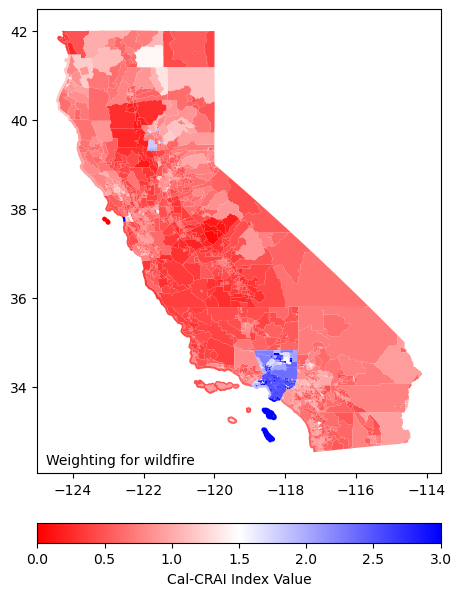

In [14]:
index_plot(df_fire, 'wildfire_scenario_calcrai_score', scenario='wildfire', vmin=0, vmax=3)

## Extreme Heat

In [15]:
df_heat = weight_domains(community_capacity_climate_hazards, society=0.87, built=0.81, natural=0.45)
df_heat = calculate_weighted_index(df_heat, 'extreme_heat_hazard_score')

# rename the index column to represent the weighting scenario
df_heat = df_heat.rename(columns={'calcrai_score':'extreme_heat_scenario_calcrai_score'})

df_heat.to_csv('calcrai_heat_scenario_index.csv', index=False)
print_index_summary(df_heat, 'extreme_heat_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  42.13018758263449
Mean score / average resilience:  1.1272729793054699
Median score / median resilience:  0.7386808299198497


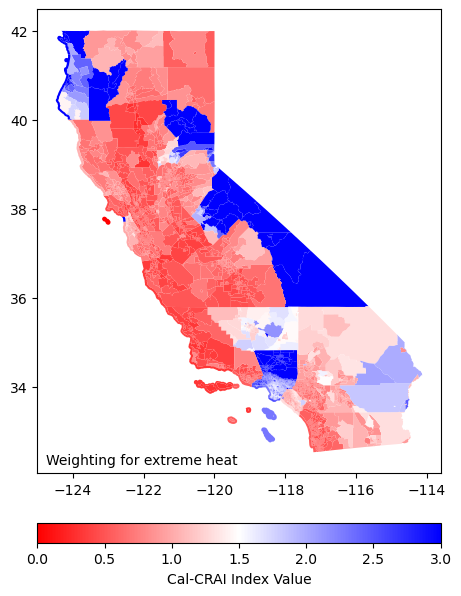

In [16]:
index_plot(df_heat, 'extreme_heat_scenario_calcrai_score', scenario='extreme heat', vmin=0, vmax=3)

## Inland Flooding

In [17]:
df_inland_flooding = weight_domains(community_capacity_climate_hazards, society=0.92, built=0.83, natural=0.21)
df_inland_flooding = calculate_weighted_index(df_inland_flooding, 'inland_flooding_hazard_score')

# rename the index column to represent the weighting scenario
df_inland_flooding = df_inland_flooding.rename(columns={'calcrai_score':'inland_flooding_scenario_calcrai_score'})

df_inland_flooding.to_csv('calcrai_inland_flooding_scenario_index.csv', index=False)
print_index_summary(df_inland_flooding, 'inland_flooding_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  6.905770664594272
Mean score / average resilience:  1.1871824942941893
Median score / median resilience:  0.9084109774761876


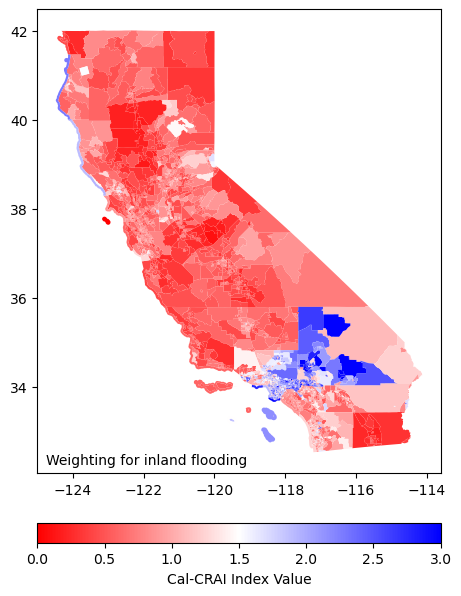

In [18]:
index_plot(df_inland_flooding, 'inland_flooding_scenario_calcrai_score', scenario='inland flooding', vmin=0, vmax=3)

## Sea Level Rise

In [19]:
df_sea_level_rise = weight_domains(community_capacity_climate_hazards, society=0.92, built=0.75, natural=0.56)
df_sea_level_rise = calculate_weighted_index(df_sea_level_rise, 'sea_level_rise_hazard_score')

# rename the index column to represent the weighting scenario
df_sea_level_rise = df_sea_level_rise.rename(columns={'calcrai_score':'sea_level_rise_scenario_calcrai_score'})

df_sea_level_rise.to_csv('calcrai_sea_level_rise_scenario_index.csv', index=False)
print_index_summary(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score')


Min score / less resilience:  0.0
Max score / more resilience:  8.940740043889454
Mean score / average resilience:  1.297204031238819
Median score / median resilience:  0.9434829030632987


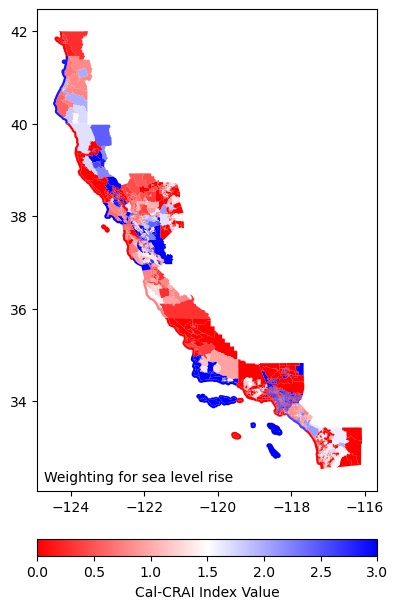

In [20]:
index_plot(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score', scenario='sea level rise',  vmin=0, vmax=3)

## Drought

In [21]:
df_drought = weight_domains(community_capacity_climate_hazards, society=0.85, built=0.95, natural=0.21)
df_drought = calculate_weighted_index(df_drought, 'drought_hazard_score')

# rename the index column to represent the weighting scenario
df_drought = df_drought.rename(columns={'calcrai_score':'drought_scenario_calcrai_score'})

df_drought.to_csv('calcrai_drought_scenario_index.csv', index=False)
print_index_summary(df_drought, 'drought_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  24.916581201325332
Mean score / average resilience:  1.9905426195461893
Median score / median resilience:  1.3893399678416207


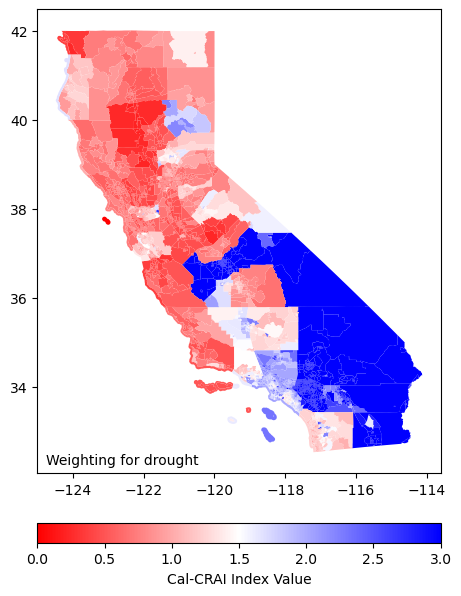

In [22]:
index_plot(df_drought, 'drought_scenario_calcrai_score', scenario='drought',  vmin=0, vmax=3)

## Step 3: Bin Data
### 3a) Merge index scores per scenario together

In [23]:
# List of dataframes to merge
dfs = [df_drought, df_fire, df_heat, df_sea_level_rise, df_inland_flooding]

# Keep only 'geoid' and columns ending with '_calcrai_score' in each dataframe
dfs = [df[['GEOID'] + [col for col in df.columns if col.endswith('_calcrai_score')]] for df in dfs]

# Merge all dataframes on 'geoid' using an outer join
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GEOID', how='outer'), dfs)

# View the resulting merged dataframe
merged_df

,GEOID,drought_scenario_calcrai_score,wildfire_scenario_calcrai_score,extreme_heat_scenario_calcrai_score,sea_level_rise_scenario_calcrai_score,inland_flooding_scenario_calcrai_score
0,06001400100,0.525923,0.858811,0.611556,1.561069,0.758609
1,06001400200,0.474638,0.680031,0.520449,1.274879,1.044794
2,06001400300,0.455644,0.620233,0.453456,1.309211,0.646648
3,06001400400,0.441344,0.607397,0.445585,1.197214,0.945964
4,06001400500,0.422158,0.569228,0.416860,1.067489,0.597561
...,...,...,...,...,...,...
9124,06115040902,1.376249,0.547621,1.234857,NaN,0.754595
9125,06115041001,1.125804,0.430948,1.040315,NaN,0.706053
9126,06115041002,1.357107,0.566273,1.265469,NaN,0.790040
9127,06115041101,1.026210,0.608326,1.276096,NaN,0.719920


## 3b) Bin values into 5 sections per scenario

In [24]:
# Binning into quartiles
binned_df = merged_df.copy()

# Define the columns to bin
columns_to_bin = [
    'drought_scenario_calcrai_score',
    'wildfire_scenario_calcrai_score',
    'extreme_heat_scenario_calcrai_score',
    'sea_level_rise_scenario_calcrai_score',
    'inland_flooding_scenario_calcrai_score',
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_df = binned_df.drop(columns=columns_to_bin)
binned_df

Bin edges for drought_scenario_calcrai_score: [ 0.          0.60562818  1.13045149  1.67352195  2.12797341 24.9165812 ]
Bin edges for wildfire_scenario_calcrai_score: [0.         0.55736778 0.6830717  0.83560298 2.93694123 8.64916661]
Bin edges for extreme_heat_scenario_calcrai_score: [ 0.          0.4836741   0.62456182  0.90909209  1.85249904 42.13018758]
Bin edges for sea_level_rise_scenario_calcrai_score: [0.         0.59790156 1.20123457 2.63230528 8.94074004]
Bin edges for inland_flooding_scenario_calcrai_score: [0.         0.55305944 0.75643066 1.07247769 2.02189634 6.90577066]


,GEOID,drought_scenario_calcrai_score_quartile,wildfire_scenario_calcrai_score_quartile,extreme_heat_scenario_calcrai_score_quartile,sea_level_rise_scenario_calcrai_score_quartile,inland_flooding_scenario_calcrai_score_quartile
0,06001400100,0,3,1,2.0,2
1,06001400200,0,1,1,2.0,2
2,06001400300,0,1,0,2.0,1
3,06001400400,0,1,0,1.0,2
4,06001400500,0,1,0,1.0,1
...,...,...,...,...,...,...
9124,06115040902,2,0,3,NaN,1
9125,06115041001,1,0,3,NaN,1
9126,06115041002,2,1,3,NaN,2
9127,06115041101,1,1,3,NaN,1


In [25]:
# save as a csv file
binned_df.to_csv('binned_weighted_data.csv', index=False)

In [26]:
# for plotting labels
binned_df_viz = binned_df.copy()

# SLR is slightly difference since 0-40% is 0
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 0, 'sea_level_rise_scenario_calcrai_score_quartile'] = '0-40%'
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 1, 'sea_level_rise_scenario_calcrai_score_quartile'] = '40-60%'
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 2, 'sea_level_rise_scenario_calcrai_score_quartile'] = '60-80%'
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 3, 'sea_level_rise_scenario_calcrai_score_quartile'] = '80+%'

# remainder of risks
binned_df_viz = binned_df_viz.replace(0, '0-20%')
binned_df_viz = binned_df_viz.replace(1, '20-40%')
binned_df_viz = binned_df_viz.replace(2, '40-60%')
binned_df_viz = binned_df_viz.replace(3, '60-80%')
binned_df_viz = binned_df_viz.replace(4, '80+%')

/tmp/ipykernel_1942/952045860.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0-40%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 0, 'sea_level_rise_scenario_calcrai_score_quartile'] = '0-40%'


In [27]:
binned_df_viz

,GEOID,drought_scenario_calcrai_score_quartile,wildfire_scenario_calcrai_score_quartile,extreme_heat_scenario_calcrai_score_quartile,sea_level_rise_scenario_calcrai_score_quartile,inland_flooding_scenario_calcrai_score_quartile
0,06001400100,0-20%,60-80%,20-40%,60-80%,40-60%
1,06001400200,0-20%,20-40%,20-40%,60-80%,40-60%
2,06001400300,0-20%,20-40%,0-20%,60-80%,20-40%
3,06001400400,0-20%,20-40%,0-20%,40-60%,40-60%
4,06001400500,0-20%,20-40%,0-20%,40-60%,20-40%
...,...,...,...,...,...,...
9124,06115040902,40-60%,0-20%,60-80%,NaN,20-40%
9125,06115041001,20-40%,0-20%,60-80%,NaN,20-40%
9126,06115041002,40-60%,20-40%,60-80%,NaN,40-60%
9127,06115041101,20-40%,20-40%,60-80%,NaN,20-40%


## 3c) Visualize the binned weighted scenarios

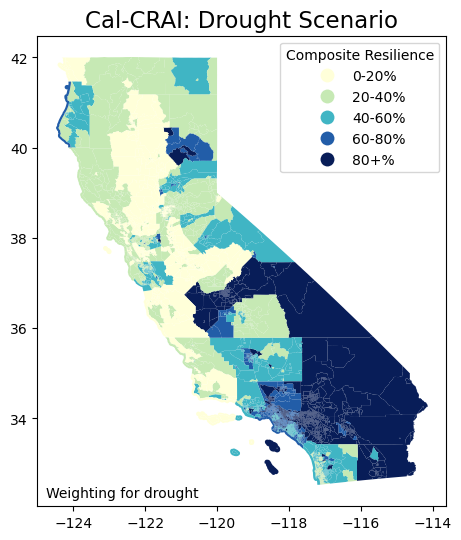

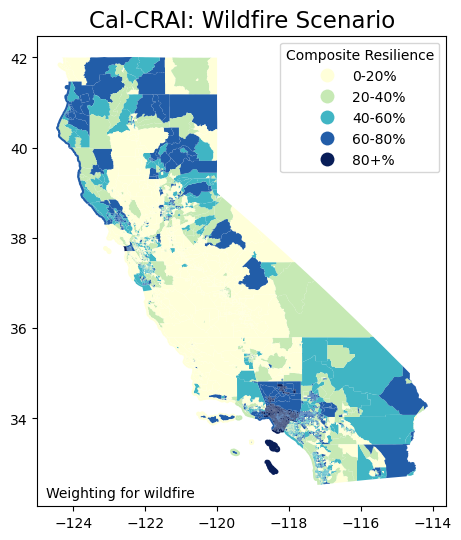

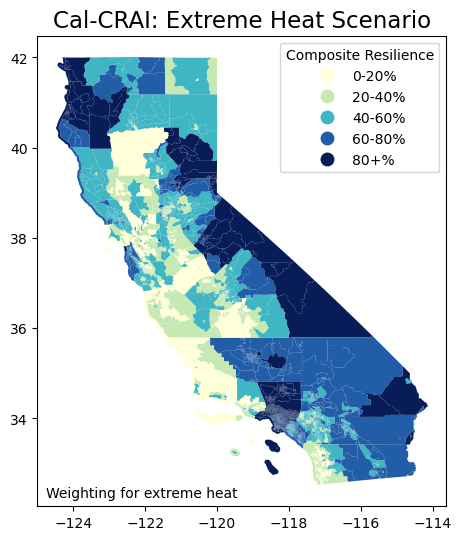

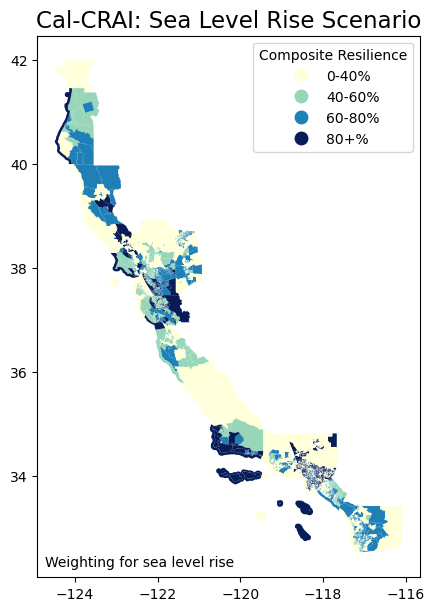

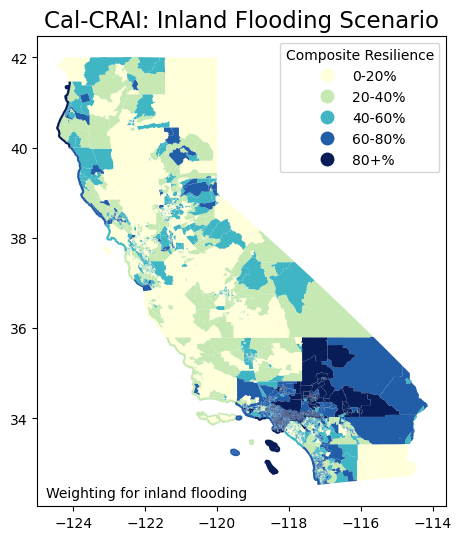

In [28]:
# List of binned columns
binned_columns = [
    'drought_scenario_calcrai_score_quartile',
    'wildfire_scenario_calcrai_score_quartile',
    'extreme_heat_scenario_calcrai_score_quartile',
    'sea_level_rise_scenario_calcrai_score_quartile',
    'inland_flooding_scenario_calcrai_score_quartile',
]

# Loop through each binned column and plot
for column in binned_columns:
    scenario_name = column.split('_scenario')[0]  # Get everything before '_scenario'
    scenario_name = scenario_name.replace('_', ' ')

    index_plot(binned_df_viz, column, save_name=f'binned {scenario_name}', scenario=scenario_name, plot_title=True, vmin=0, vmax=5, plot_type='discrete')

## Step 4) Upload each scenario index .csv to AWS

In [29]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files = ['calcrai_wildfire_scenario_index.csv',
        'calcrai_heat_scenario_index.csv',
        'calcrai_inland_flooding_scenario_index.csv',
        'calcrai_sea_level_rise_scenario_index.csv',
        'calcrai_drought_scenario_index.csv']

for file in files:
    upload_csv_aws([file], bucket_name, directory)

calcrai_wildfire_scenario_index.csv uploaded to AWS
calcrai_heat_scenario_index.csv uploaded to AWS
calcrai_inland_flooding_scenario_index.csv uploaded to AWS
calcrai_sea_level_rise_scenario_index.csv uploaded to AWS
calcrai_drought_scenario_index.csv uploaded to AWS
